In [10]:
import numpy as np
import matplotlib.pyplot as plt
import onnxruntime as ort
import tqdm
import cv2

model_path = '../xfeat_detectAndCompute.onnx'

#Load some example images
im1 = cv2.imread('../assets/ref.png', cv2.IMREAD_COLOR)

In [11]:
def draw_keypoints(image, keypoints, scores):
    for i in range(keypoints.shape[0]):
        x, y = keypoints[i]
        cv2.circle(image, (int(x), int(y)), 1, np.array([0, 0, 255]) * scores[i], -1)
    return image

In [12]:
tmp_ort_session = ort.InferenceSession(model_path, providers=['CPUExecutionProvider'])

# print the input,output names and shapes
for i in range(len(tmp_ort_session.get_inputs())):
    print(f"Input name: {tmp_ort_session.get_inputs()[i].name}, shape: {tmp_ort_session.get_inputs()[i].shape}")
for i in range(len(tmp_ort_session.get_outputs())):
    print(f"Output name: {tmp_ort_session.get_outputs()[i].name}, shape: {tmp_ort_session.get_outputs()[i].shape}")


providers = [
    ('TensorrtExecutionProvider', { 
        'device_id': 0,
        'trt_max_workspace_size': 1 * 1024 * 1024 * 1024,
        'trt_fp16_enable': True,
        'trt_engine_cache_enable': True,
        'trt_engine_cache_path': './trt_engine_cache',
        'trt_engine_cache_prefix': 'xfeat',
        'trt_dump_subgraphs': False,
        'trt_timing_cache_enable': True,
        'trt_timing_cache_path': './trt_engine_cache',
        #'trt_builder_optimization_level': 3,
    }),
    ('CUDAExecutionProvider', {
        'device_id': 0,
        'gpu_mem_limit': 1 * 1024 * 1024 * 1024,
    }),
    ('CPUExecutionProvider',{ 
    })
]
ort_session = ort.InferenceSession(model_path, providers=providers)

Input name: images, shape: [1, 3, 'height', 'width']
Input name: top_k, shape: []
Output name: keypoints, shape: ['ScatterNDkeypoints_dim_0', 'ScatterNDkeypoints_dim_1', 2]
Output name: scores, shape: ['Slicescores_dim_0', 'Slicescores_dim_1']
Output name: descriptors, shape: ['Divdescriptors_dim_0', 'Divdescriptors_dim_1', 'Divdescriptors_dim_2']


## Prepare the input tensor

In [13]:
# im1 = cv2.resize(im1, (640, 640)) # for bechmarking

input_array_1 = im1.transpose(2, 0, 1).astype(np.float32)
input_array_1 = np.expand_dims(input_array_1, axis=0)

top_k = np.array(4800, dtype=np.int64)

inputs = {
    ort_session.get_inputs()[0].name: input_array_1,
    ort_session.get_inputs()[1].name: top_k,
}

## Run

In [14]:
outputs = ort_session.run(None, inputs)

In [15]:
for i in range(len(outputs)):
    print(f"Output name: {ort_session.get_outputs()[i].name}, shape: {outputs[i].shape}")

Output name: keypoints, shape: (1, 4800, 2)
Output name: scores, shape: (1, 4800)
Output name: descriptors, shape: (1, 4800, 64)


In [16]:
keypoints = outputs[0]
scores = outputs[1]
descriptors = outputs[2]

valid = scores > 0.0

keypoints = keypoints[valid]
scores = scores[valid]
descriptors = descriptors[valid]

print('keypoints', keypoints.shape)
print('scores', scores.shape)
print('descriptors', descriptors.shape)

keypoints (4800, 2)
scores (4800,)
descriptors (4800, 64)


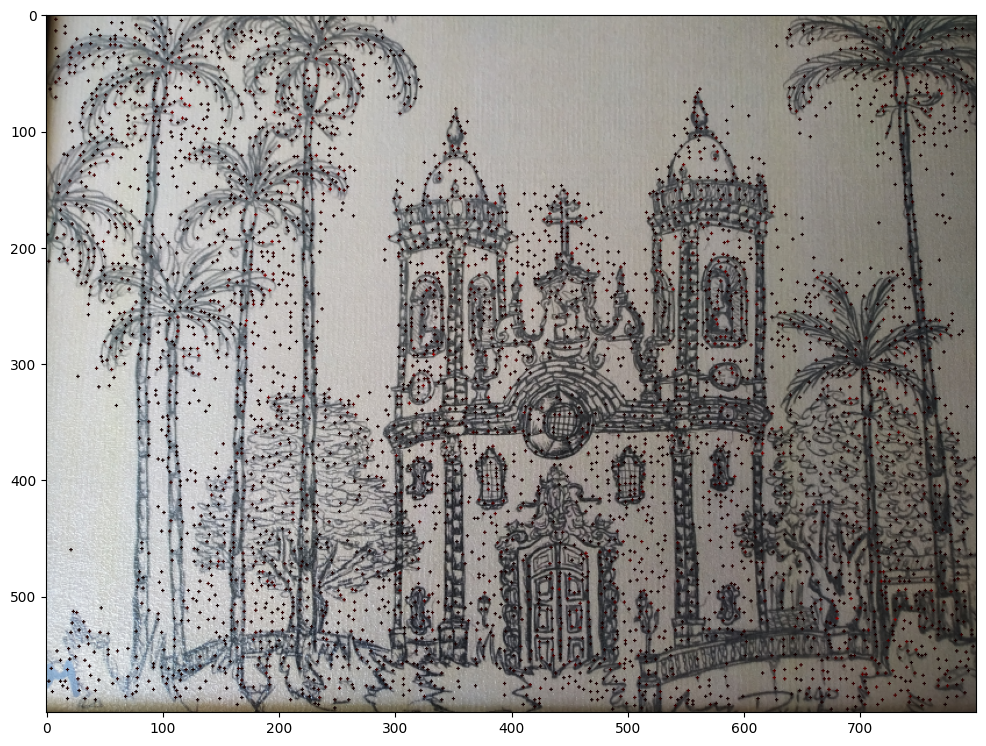

In [17]:
canvas = draw_keypoints(im1.copy(), keypoints, scores)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1])
plt.show()
plt.close()

In [18]:
import time

# Run the model 100 times to get an average time
loop = 100
start = time.perf_counter()
for i in tqdm.tqdm(range(loop)):
    outputs = ort_session.run(None, inputs)
duration = time.perf_counter()-start

print(f"Average time per batch: {duration/loop:.4f} seconds")
print(f"Average time per image: {duration/loop:.4f} seconds")
print(f"Average FPS per image: {loop/duration:.4f}")

100%|██████████| 100/100 [00:05<00:00, 17.99it/s]

Average time per batch: 0.0556 seconds
Average time per image: 0.0556 seconds
Average FPS per image: 17.9832
